# Analyzing SemCor data and results

Load the predictions for different embedding types and Xs

(Predictions are obtained with the script make_semcor_predictions.py

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from utils import *
from scipy.stats import spearmanr, pearsonr, kendalltau

## Looking at the datasets




In [4]:
# Load gold standard
gs = pd.read_csv("semcor_predictions/gold_standard-senses.csv", sep="\t")

### Jensen Shannon Divergence: the amount of change 

In [7]:
def make_JSD_histograms(goldstandard, X="all", dataset_name='Semcor'):
    
    fig = plt.figure()

    alpha = 0.2 if X == "all" else 1
    col_key = "s_JSD"
    for col in goldstandard.columns:
        if col.startswith(col_key):
            num_sentences = col.split("_")[2][1:]
            if int(num_sentences) == X or X == "all":
                plt.hist(goldstandard[col], alpha=alpha, bins=30, label=num_sentences)  # , histtype=u"step")
    plt.legend()    
    plt.suptitle("JSD distribution in " + dataset_name)
    plt.title("Different dataset sizes (X = number of sentences")
    plt.xlabel("Jensen Shannon Divergence")
    plt.ylabel("Number of lemmas")
    fig.set_dpi(100)
    plt.show()


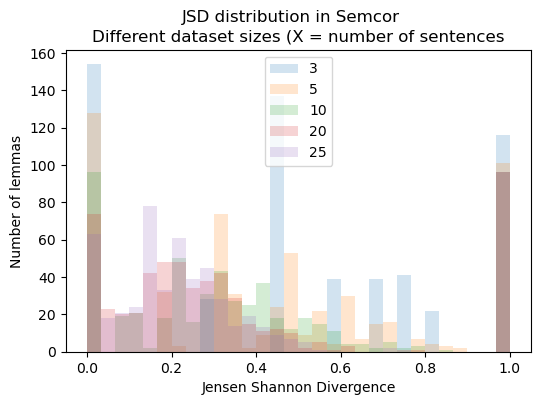

In [8]:
make_JSD_histograms(gs, X="all")

In [10]:
for X in [3,25]:
    print(X)
    print("mean JSD", str(X),np.average(gs['s_JSD_X' + str(X)]))
    print("median JSD", str(X), np.median(gs['s_JSD_X' + str(X)]))
    print("JSD over 0.5:", len([x for x in gs['s_JSD_X' + str(X)] if x > 0.5]))

3
mean JSD 3 0.48906189790309784
median JSD 3 0.4555422588952882
JSD over 0.5: 257
25
mean JSD 25 0.33451230856731634
median JSD 25 0.22783083732218085
JSD over 0.5: 104



### POS proportions


In [11]:
def make_pos_proportion_barplot(goldstandard, dataset_name='Semcor'):
    poss = ['n','v','a','r']
    pos = goldstandard['pos']
    c = Counter(pos)
    print(c)

    plt.bar(range(len(c)), [c[p] for p in poss], tick_label = poss)
    plt.suptitle("POS distribution in " + dataset_name)
    plt.xlabel("POS")
    plt.ylabel("Number of lemmas")
    plt.show()

Counter({'v': 245, 'n': 241, 'a': 69, 'r': 21})


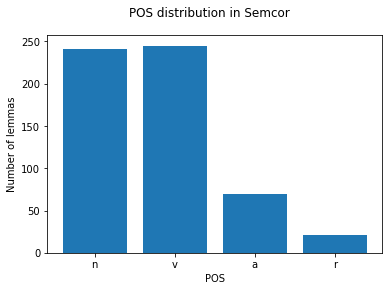

In [12]:
make_pos_proportion_barplot(gs)

# Results 


In [17]:
colors = dict()
colors['c2v'] = 'mediumblue'
colors['ALC'] = 'green'

## Loading predictions

In [19]:
import os
all_vector_types = ["c2v", "ALC-840B.300d"]
for i in range(0,13):
    all_vector_types.append("bert-"+str(i))

predictions = dict()
for vector_type in all_vector_types:
    predictions[vector_type] = dict()
    path = "semcor_predictions/" + vector_type + "/"
    for method in os.listdir(path):
        predictions[vector_type][method.split(".")[0]] = pd.read_csv(path + method, sep="\t")

In [20]:
predictions['ALC-840B.300d']['cosine']

,lemma,pos,cosine_X3,cosine_X5,cosine_X10,cosine_X20,cosine_X25
0,evidence,n,0.330257,0.192765,0.086054,0.041405,0.031172
1,conduct,v,0.250189,0.228735,0.055490,0.051068,0.045731
2,follow,v,0.402359,0.188349,0.113035,0.041854,0.037730
3,policy,n,0.276921,0.149411,0.060336,0.051659,0.033287
4,place,v,0.359837,0.209093,0.123588,0.061582,0.052052
...,...,...,...,...,...,...,...
571,sleep,v,0.242580,0.143860,0.064113,0.020097,0.017631
572,shake,v,0.292573,0.222653,0.087066,0.041032,0.025658
573,wage,n,0.255678,0.109228,0.052058,0.017536,0.010369
574,shelter,n,0.269431,0.092362,0.050792,0.024659,0.017901


## c2v vs ALC


c2v
c2v {3: 0.21119518252986308, 5: 0.28922212047852236, 10: 0.34500714606216876, 20: 0.3277527060042523, 25: 0.3264887115103065}
ALC-840B.300d
ALC-840B.300d {3: 0.02332694042802996, 5: 0.045983535868171645, 10: 0.087052288813563, 20: 0.2091363653295424, 25: 0.23561277465390895}


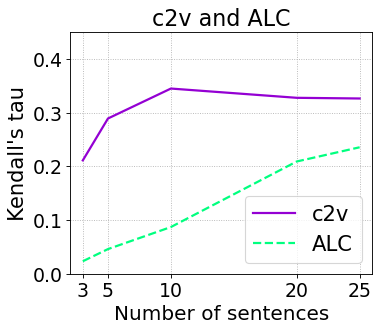

In [23]:


def results_all_vector_types_one_ds(predictions):
    styles = ['-','--']
    vector_names = ['c2v','ALC']
    Xs = [3, 5, 10, 20, 25]
    colors = ["darkviolet", "springgreen"]
    fig = plt.figure()
    senseintr = "s"    
    for i, vector_type in enumerate(['c2v', 'ALC-840B.300d']): 
        print(vector_type)
        results = dict()        
        for X in Xs:        
            gscol = senseintr + "_JSD_X" + str(X)            
            df = predictions[vector_type]['cosine']
            col = [c for c in df.columns if c.split("_")[-1] == "X" + str(X) and "JSD" not in c][0]            
            results[X] = kendalltau(df[col], gs[gscol])[0]   
        print(vector_type, results)
        plt.plot(Xs, [results[X] for X in Xs], label=vector_names[i], linewidth=2, linestyle=styles[i], color=colors[i]) #color=colors[vector_type.split("-")[0]][ds])

    plt.xlim(2, Xs[-1] + 1)
    plt.xticks(Xs, size=17)
    plt.ylim(0, 0.45)
    plt.yticks([0,0.1,0.2,0.3,0.4], size=17)
    fig.set_dpi(80)
    plt.legend(fontsize=19)
    plt.ylabel("Kendall's tau", size=19) # 14
    
    plt.xlabel("Number of sentences", size=18)
    plt.title("c2v and ALC", size=20) 
  
    ratio = 0.8
    x_left, x_right = plt.xlim()    
    y_low, y_high = plt.ylim()   
    plt.grid(linestyle=":")
    
    
    plt.gca().set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
    

    plt.show()
        
        
        
results_all_vector_types_one_ds(predictions)

# c2v: results by POS, random dataset

In [26]:
plt.style.use('tableau-colorblind10')

def plot_by_pos(predictions, vector_type):    
    Xs = [3, 5, 10, 20, 25]
    posd = {"n":"NOUN","v":'VERB',"a":"ADJECTIVE","r":"ADVERB"}
    colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00'] # CB color cycle
    fig = plt.figure()
    
    senseintr = "s"
    
    for posnum, pos in enumerate(['n','v','a','r']):
        results = dict()
        for X in Xs:        
            gscol = senseintr + "_JSD_X" + str(X)
            df = predictions[vector_type]['cosine'] #[sense_type]
            gsdata = [r[gscol] for i, r in gs.iterrows() if r['pos'] == pos]
            ##gsdata = [r[gscol] for i, r in df.iterrows() if r['pos'] == pos]
            col = [c for c in df.columns if c.split("_")[-1] == "X" + str(X) and "JSD" not in c][0]
            preddata = [r[col] for i, r in df.iterrows() if r['pos'] == pos]
            results[X] = kendalltau(gsdata, preddata)[0]             
        plt.plot(Xs, [results[X] for X in Xs], label=pos, linewidth=2, color=colors[posnum])
    


    plt.xlim(2, Xs[-1] + 1)
    plt.xticks(Xs, size=12)
    plt.ylim(-0.1, 0.51)
    plt.yticks([-0.1, 0,0.1,0.2,0.3,0.4,0.5], size=12)
    fig.set_dpi(80)
    plt.legend(loc='lower left', ncol=4, fontsize=13, bbox_to_anchor=(1, 0.5))#, bbox_to_anchor=(0.5, 1.5))
    plt.ylabel("Kendall's tau", size=14)
    
    plt.xlabel("X", size=13)
    
    plt.title(vector_type + " performance by POS", size=15) # (" + dataset + " dataset, " + sense_type + ")")  
    plt.grid(linestyle=":")
       

    ratio = 0.8
    x_left, x_right = plt.xlim()    
    y_low, y_high = plt.ylim()   
    
    
    plt.gca().set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
    

   
    plt.show()

## c2v: results by POS

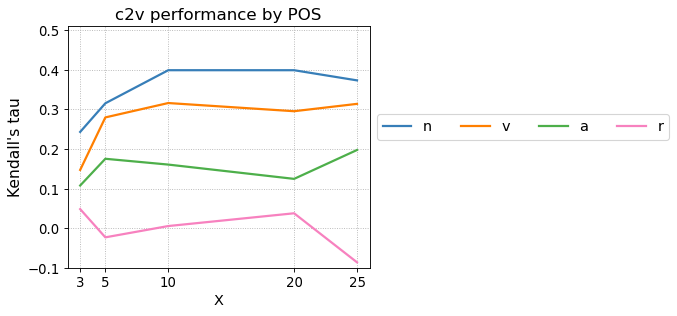

In [27]:
plot_by_pos(predictions, vector_type="c2v")


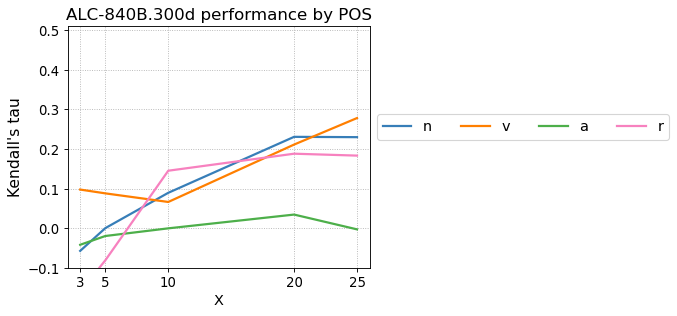

In [31]:
plot_by_pos(predictions, vector_type="ALC-840B.300d")

# ---------------- BERT --------------------



## BERT performance by layer and X

bert-12 {3: 0.32144761267048405, 5: 0.36215932754416214, 10: 0.3991298228341907, 20: 0.42361791561682616, 25: 0.4238291981250828}
bert-10 {3: 0.323478335579425, 5: 0.3682437926361998, 10: 0.40202035253288065, 20: 0.4346445780248746, 25: 0.42589371726242936}
bert-8 {3: 0.3186256990177998, 5: 0.3689184299790408, 10: 0.4051600658262853, 20: 0.42260425382595174, 25: 0.4144362420336797}
bert-6 {3: 0.2963536795814275, 5: 0.35533658007694, 10: 0.3936851612896756, 20: 0.40162639944651424, 25: 0.3980898838085675}
bert-4 {3: 0.2513612992872284, 5: 0.31008496208071845, 10: 0.3581515806833665, 20: 0.3581872831887986, 25: 0.35510156676401927}
bert-2 {3: 0.19316922008491286, 5: 0.24688544496363274, 10: 0.29829768123290756, 20: 0.2933570803662, 25: 0.2944595800043186}


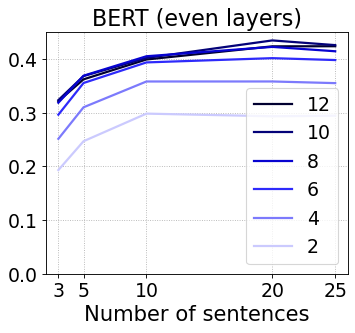

In [33]:
#import matplotlib.colors as mcolors


def results_BERT_one_ds(predictions):    
    colors = ["#cbcafe", "#7c7afc", "#2e2afb","#0703d0", "#040278", "#010030"] #["#BCD2E8","#91BAD6","#73A5C6","#528AAE","#2E5984","#1E3F66"]
    colors.reverse()
    Xs = [3, 5, 10, 20, 25]
    fig = plt.figure()
    senseintr = "s"   
    all_results = dict()
    for i, layer in enumerate(range(12, 1, -2)):
        all_results[layer] = dict()
        results = dict()
        vector_type = "bert-" + str(layer)
        for X in Xs:        
            gscol = senseintr + "_JSD_X" + str(X)
            df = predictions[vector_type]['cosine']
            col = [c for c in df.columns if c.split("_")[-1] == "X" + str(X) and "JSD" not in c][0]            
            results[X] = kendalltau(df[col], gs[gscol])[0]   
            all_results[layer][X] = results[X]
        print(vector_type, results)
        plt.plot(Xs, [results[X] for X in Xs], label= str(layer), color=colors[i], linewidth=2)

    plt.xlim(2, Xs[-1] + 1)
    plt.xticks(Xs, size=17)     
    plt.ylim(0.0, 0.45)
    plt.yticks([0,0.1,0.2,0.3,0.4], size=17) 
    fig.set_dpi(80)    
    plt.legend(fontsize=17, loc='lower right') 
    plt.xlabel("Number of sentences", size=19)
    plt.title("BERT (even layers)", size=20) 
    
   
    ratio = 0.8
    x_left, x_right = plt.xlim()    
    y_low, y_high = plt.ylim()   
    
    
    plt.gca().set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
    plt.grid(linestyle=":")
    

    plt.show()
    return all_results

bert_results = results_BERT_one_ds(predictions)



## BERT performance by pos

### (10th layer)

bert-10 {3: 0.354967929152908, 5: 0.38436786138723816, 10: 0.42487435745371926, 20: 0.47492185219101035, 25: 0.44485474029207883}
bert-10 {3: 0.2594477613778372, 5: 0.3435483231583565, 10: 0.4111771140566608, 20: 0.4582310818401155, 25: 0.46352083150603834}
bert-10 {3: 0.1715104960072065, 5: 0.18868541421701604, 10: 0.15347472213935295, 20: 0.1613771954768993, 25: 0.173412157174993}
bert-10 {3: 0.49735464948228586, 5: 0.498017531926306, 10: 0.3599342572646699, 20: 0.32770133870365464, 25: 0.2370942955749733}


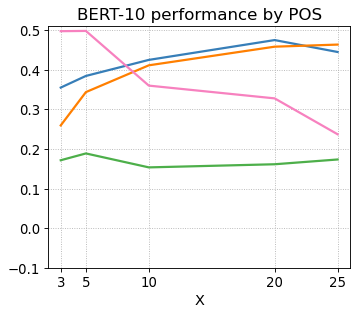

In [41]:
plt.style.use('tableau-colorblind10')

def plot_BERT_by_pos(predictions, layer):    
    Xs = [3, 5, 10, 20, 25]
    colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00'] # CB color cycle
  
    posd = {"n":"NOUN","v":'VERB',"a":"ADJECTIVE","r":"ADVERB"}
    fig = plt.figure()    
    vector_type = "bert-" + str(layer)
    senseintr = "s"
    for posnum, pos in enumerate(['n','v','a','r']):
        results = dict()
        for X in Xs:        
            gscol = senseintr + "_JSD_X" + str(X)
            df = predictions[vector_type]['cosine'] 
            gsdata = [r[gscol] for i, r in gs.iterrows() if r['pos'] == pos]
            col = [c for c in df.columns if c.split("_")[-1] == "X" + str(X) and "JSD" not in c][0]
            preddata = [r[col] for i, r in df.iterrows() if r['pos'] == pos]
            results[X] = kendalltau(gsdata, preddata)[0]             
            
        print(vector_type, results)           
        plt.plot(Xs, [results[X] for X in Xs], label=pos, linewidth=2, color=colors[posnum]) #, color=colors[vector_type][ds])
    
    
    plt.xlim(2, Xs[-1] + 1)
    plt.xticks(Xs, size=12)    
    plt.ylim(-0.1, 0.51)
    plt.yticks([-0.1, 0,0.1,0.2,0.3,0.4,0.5], size=12)
    fig.set_dpi(80)    
    plt.xlabel("X", size=13)
    plt.title("BERT-" + str(layer) + " performance by POS", size=15) # (" + dataset + " dataset, " + sense_type + ")")
    
    ratio = 0.8
    x_left, x_right = plt.xlim()    
    y_low, y_high = plt.ylim()   
    plt.grid(linestyle=":")    
    
    plt.gca().set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
    

    plt.show()
    
plot_BERT_by_pos(predictions, layer=10)